In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
trips = pq.read_table("trips09.parquet") 
trips = trips.to_pandas()
import geopandas as gpd
geo = gpd.read_file("geo.shp")
cs_nyc = gpd.read_file("cs_geo.shp")
cs = pd.read_csv("cs.csv")
zones = pd.read_csv("zones.csv")

In [2]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17962676 entries, 0 to 17962675
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   request_datetime  datetime64[us]
 1   pickup_datetime   datetime64[us]
 2   dropoff_datetime  datetime64[us]
 3   PULocationID      int32         
 4   DOLocationID      int32         
 5   trip_miles        float64       
 6   trip_time         int64         
dtypes: datetime64[us](3), float64(1), int32(2), int64(1)
memory usage: 822.3 MB


In [3]:
valid_trips = trips[trips['request_datetime'] <= trips['pickup_datetime']].copy()
valid_trips['response_time'] = (valid_trips['pickup_datetime'] - valid_trips['request_datetime']).dt.total_seconds()
stats_df = pd.DataFrame({
    "Trip Time (seconds)": valid_trips["trip_time"].describe(),
    "Trip Miles": valid_trips["trip_miles"].describe(),
    "Response Time (seconds)": valid_trips["response_time"].describe()
}).round() 
print(stats_df.to_latex())
stats_df

\begin{tabular}{lrrr}
\toprule
 & Trip Time (seconds) & Trip Miles & Response Time (seconds) \\
\midrule
count & 17789845.000000 & 17789845.000000 & 17789845.000000 \\
mean & 1280.000000 & 5.000000 & 294.000000 \\
std & 932.000000 & 6.000000 & 197.000000 \\
min & 121.000000 & 0.000000 & 0.000000 \\
25% & 629.000000 & 2.000000 & 170.000000 \\
50% & 1026.000000 & 3.000000 & 246.000000 \\
75% & 1652.000000 & 7.000000 & 362.000000 \\
max & 33105.000000 & 469.000000 & 10708.000000 \\
\bottomrule
\end{tabular}



,Trip Time (seconds),Trip Miles,Response Time (seconds)
count,17789845.0,17789845.0,17789845.0
mean,1280.0,5.0,294.0
std,932.0,6.0,197.0
min,121.0,0.0,0.0
25%,629.0,2.0,170.0
50%,1026.0,3.0,246.0
75%,1652.0,7.0,362.0
max,33105.0,469.0,10708.0


**Spatial**

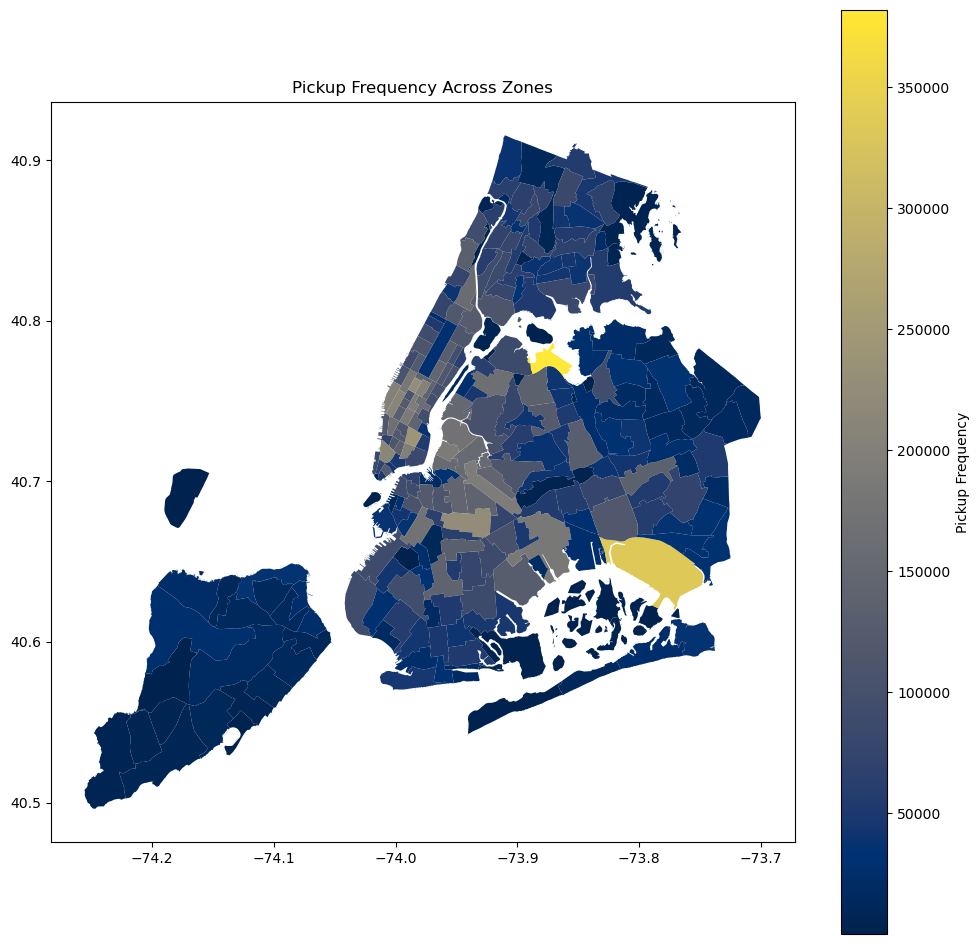

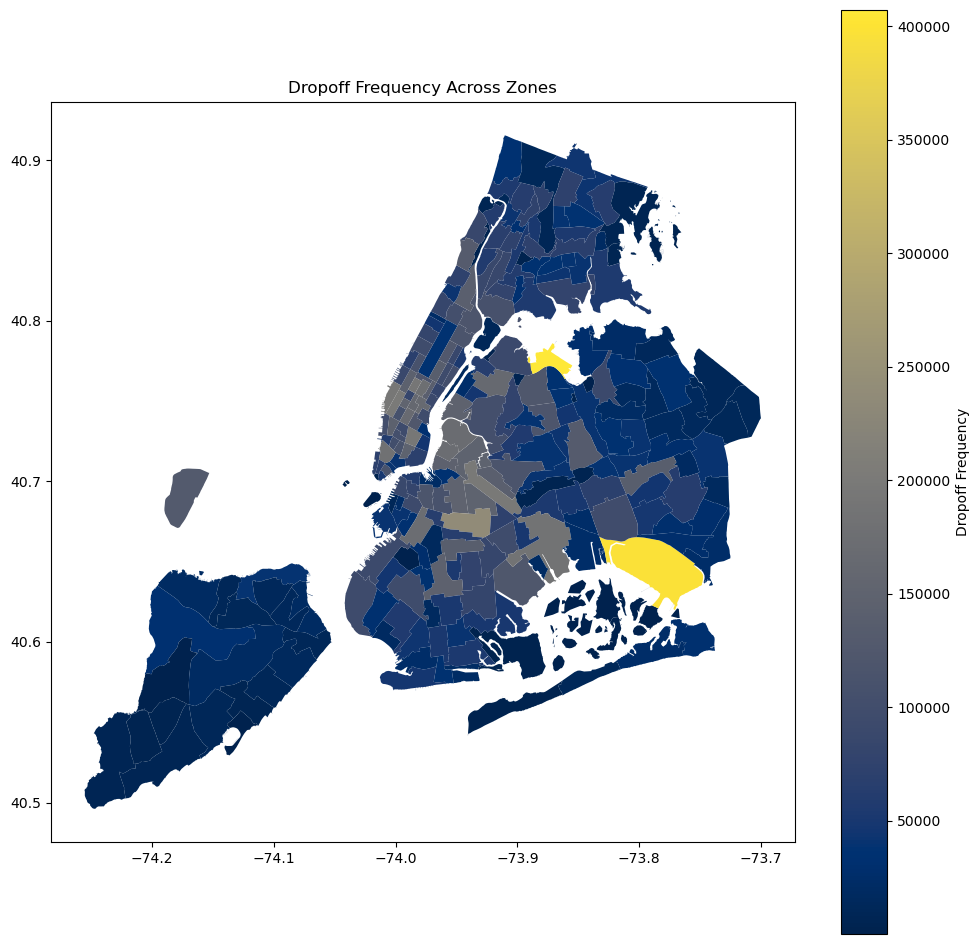

In [4]:
puFre = trips.groupby(['PULocationID']).size().reset_index(name='PUfre')
geo_puFre = geo.merge(puFre, left_on='LocationID', right_on='PULocationID', how='inner').fillna(0)
doFre = trips.groupby(['DOLocationID']).size().reset_index(name='DOfre')
geo_doFre = geo.merge(doFre, left_on='LocationID', right_on='DOLocationID', how='inner').fillna(0)

fig, ax = plt.subplots(figsize=(12, 12))
geo_puFre.plot(ax=ax, column='PUfre', cmap='cividis', legend=True, legend_kwds={'label': "Pickup Frequency"})
plt.title("Pickup Frequency Across Zones")
plt.savefig('Pickup Frequency Across Zones.png', format='png', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
geo_doFre.plot(ax=ax, column='DOfre', cmap='cividis', legend=True, legend_kwds={'label': "Dropoff Frequency"})
plt.title("Dropoff Frequency Across Zones")
plt.savefig('Dropoff Frequency Across Zones.png', format='png', dpi=1200)
plt.show()

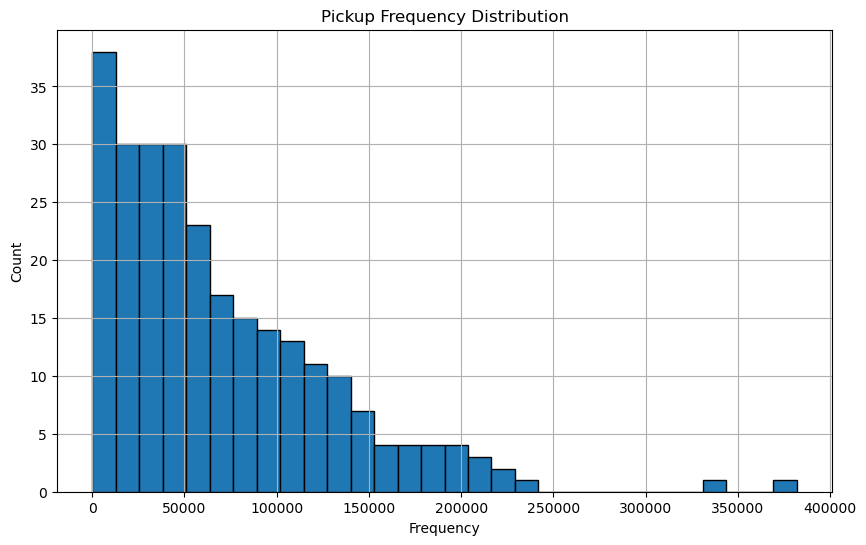

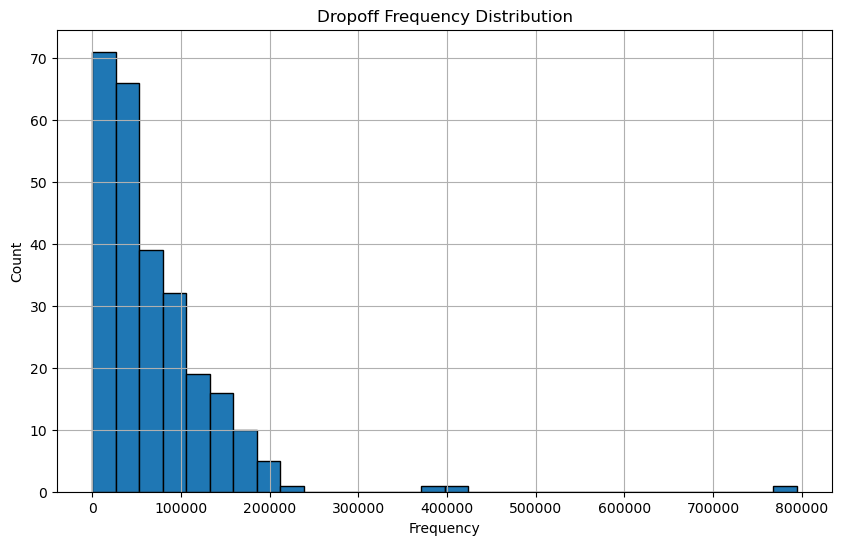

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(puFre['PUfre'], bins=30, edgecolor='black')
plt.title('Pickup Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(doFre['DOfre'], bins=30, edgecolor='black')
plt.title('Dropoff Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.grid(True)
plt.show()

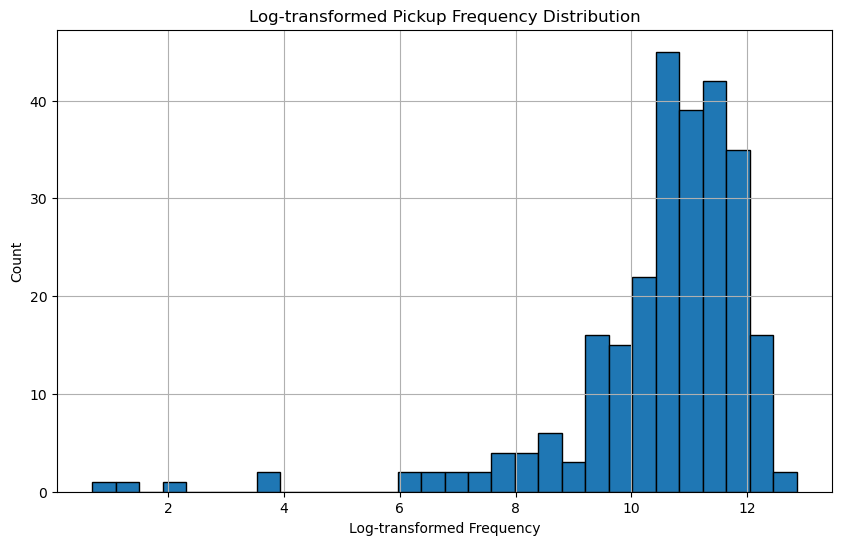

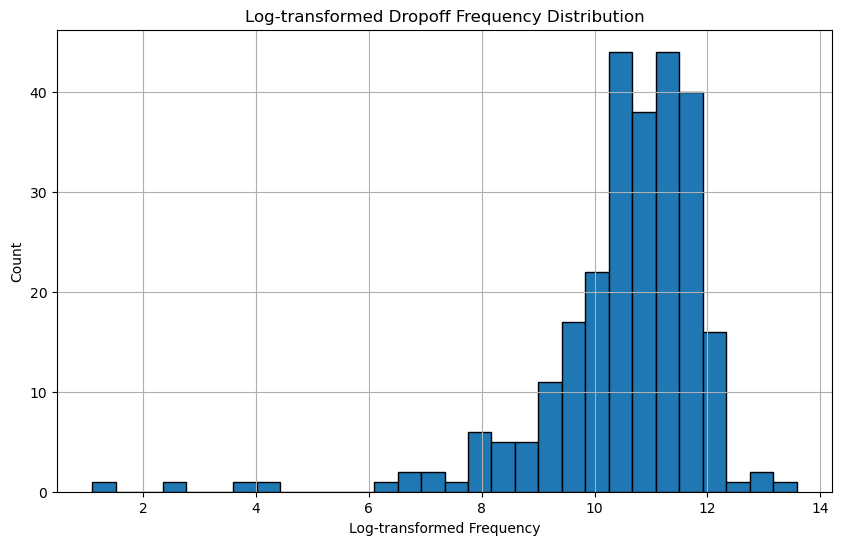

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(puFre['PUfre']), bins=30, edgecolor='black')
plt.title('Log-transformed Pickup Frequency Distribution')
plt.xlabel('Log-transformed Frequency')
plt.ylabel('Count')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(np.log1p(doFre['DOfre']), bins=30, edgecolor='black')
plt.title('Log-transformed Dropoff Frequency Distribution')
plt.xlabel('Log-transformed Frequency')
plt.ylabel('Count')
plt.grid(True)
plt.show()

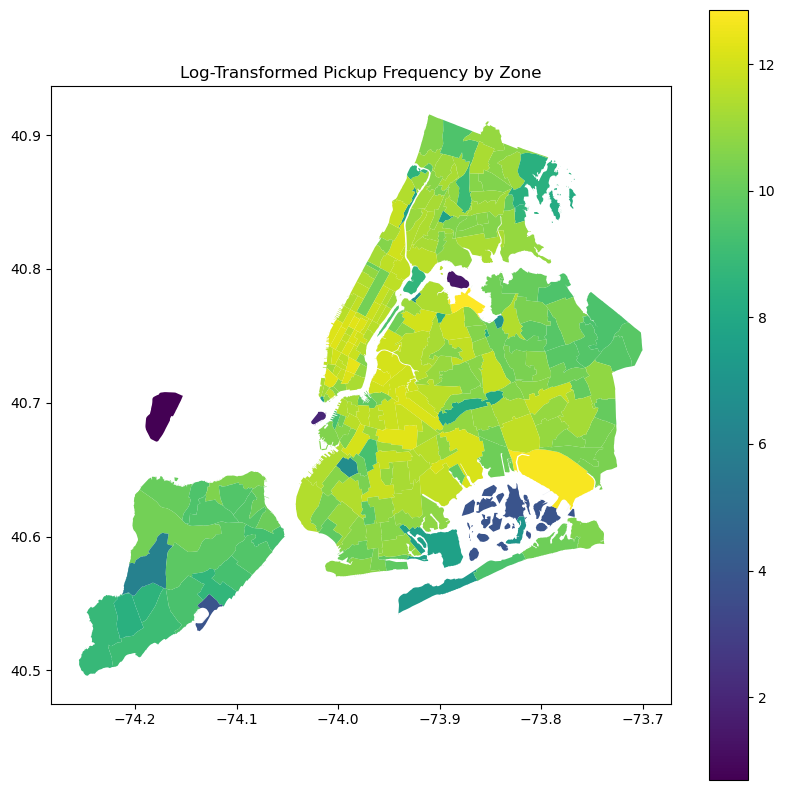

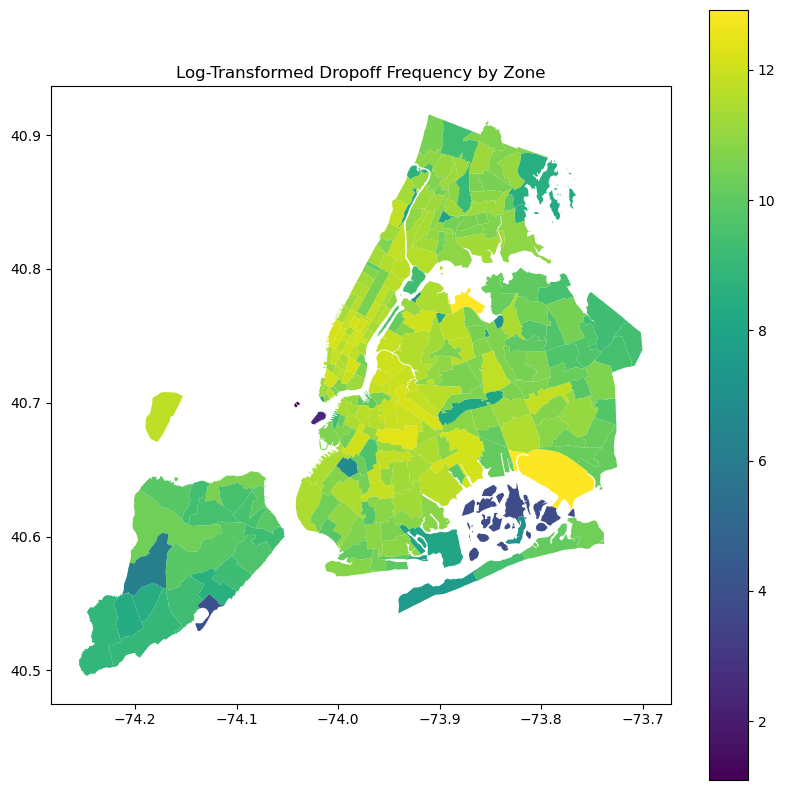

In [25]:
geo_puFre['PUfre_log'] = np.log1p(geo_puFre['PUfre'])
geo_doFre['DOfre_log'] = np.log1p(geo_doFre['DOfre'])

fig, ax = plt.subplots(figsize=(10, 10))
geo_puFre.plot(column='PUfre_log', legend=True, cmap='viridis', ax=ax)
ax.set_title("Log-Transformed Pickup Frequency by Zone")
plt.savefig("pickup_frequency_log.png", format='png', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
geo_doFre.plot(column='DOfre_log', legend=True, cmap='viridis', ax=ax)
ax.set_title("Log-Transformed Dropoff Frequency by Zone")
plt.savefig("dropoff_frequency_log.png", format='png', dpi=1200)
plt.show()

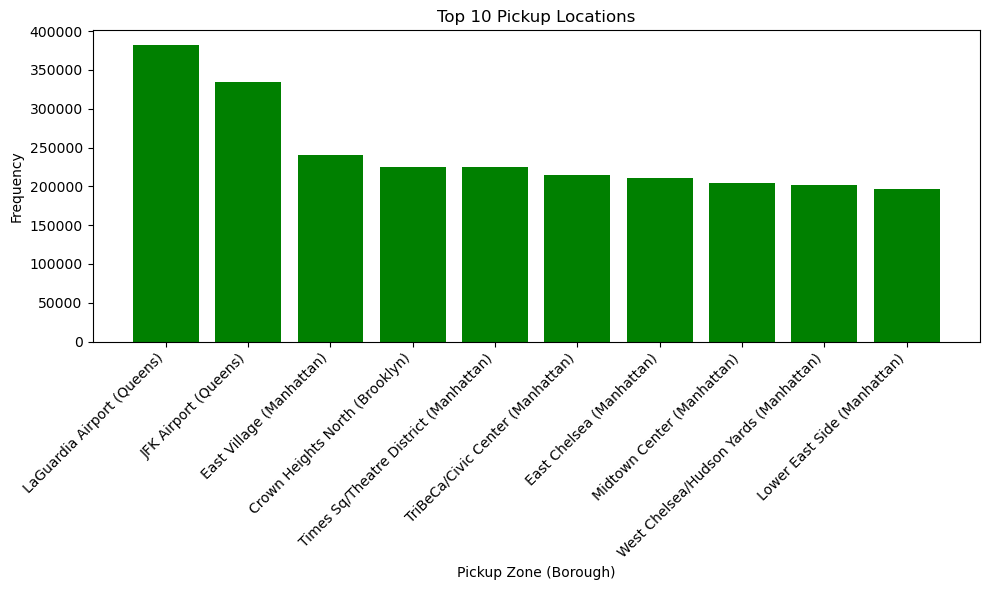

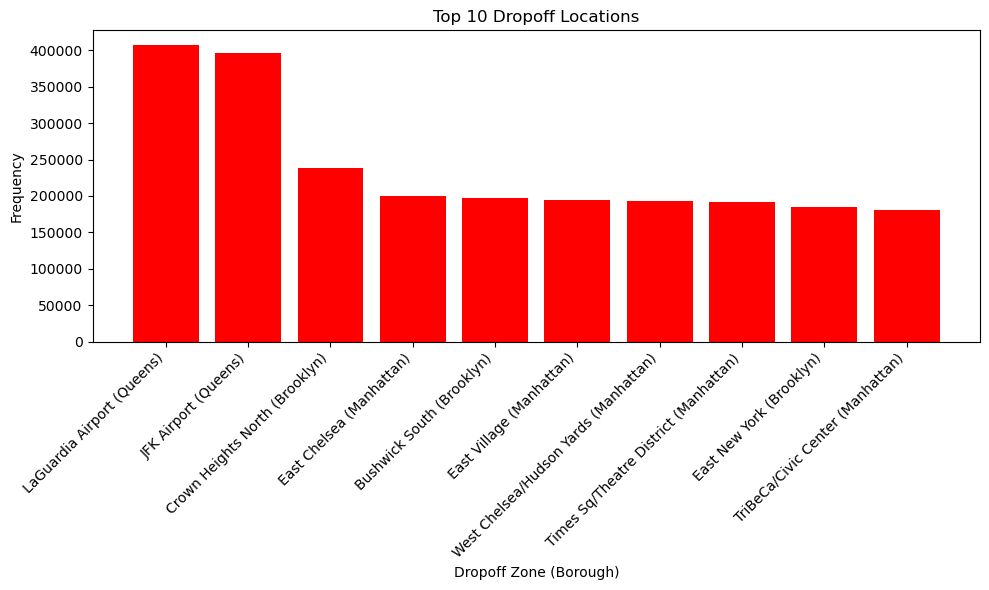

In [12]:
puFre_top10 = geo_puFre.sort_values(by='PUfre', ascending=False).head(10)
puFre_top10['Zone_Borough'] = puFre_top10['zone'] + ' (' + puFre_top10['borough'] + ')'
doFre_top10 = geo_doFre.sort_values(by='DOfre', ascending=False).head(10)
doFre_top10['Zone_Borough'] = doFre_top10['zone'] + ' (' + doFre_top10['borough'] + ')'

plt.figure(figsize=(10, 6))
plt.bar(puFre_top10['Zone_Borough'], puFre_top10['PUfre'], color='green')
plt.title('Top 10 Pickup Locations')
plt.xlabel('Pickup Zone (Borough)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_pickup_locations.png', format='png', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(doFre_top10['Zone_Borough'], doFre_top10['DOfre'], color='red')
plt.title('Top 10 Dropoff Locations')
plt.xlabel('Dropoff Zone (Borough)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_dropoff_locations.png', format='png', dpi=1200)
plt.show()

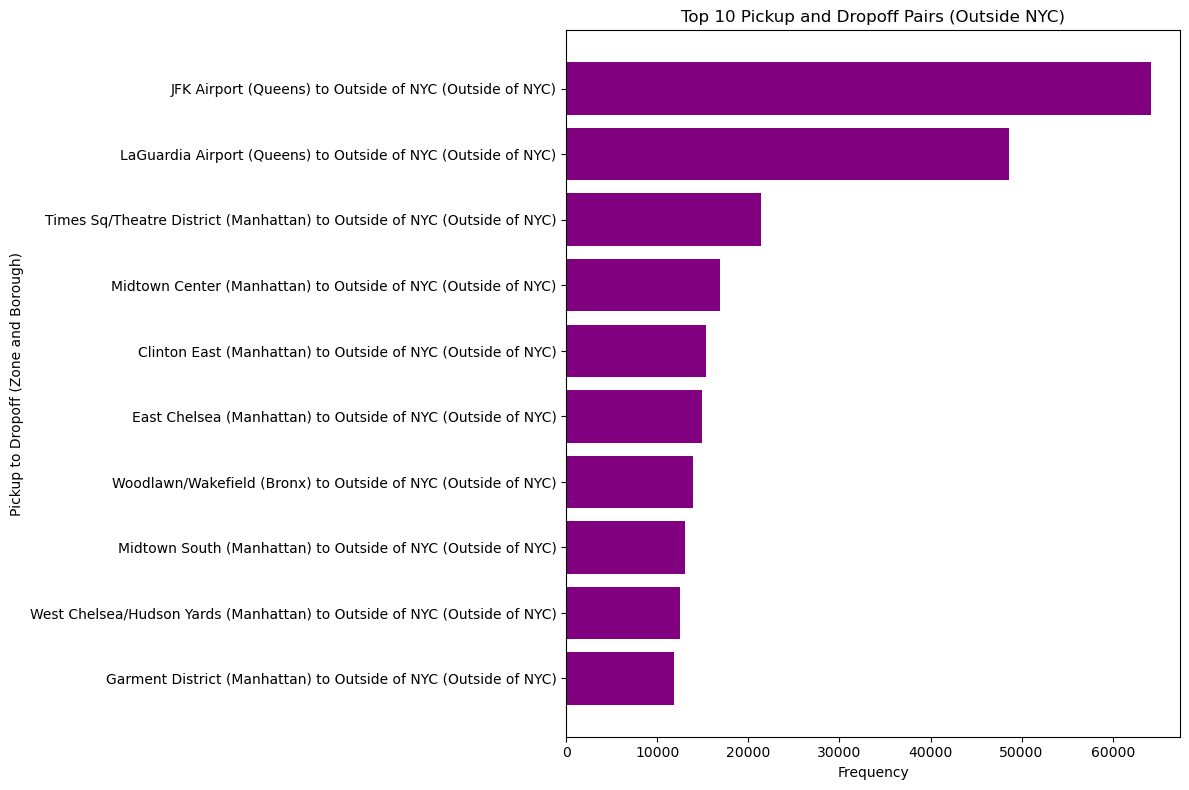

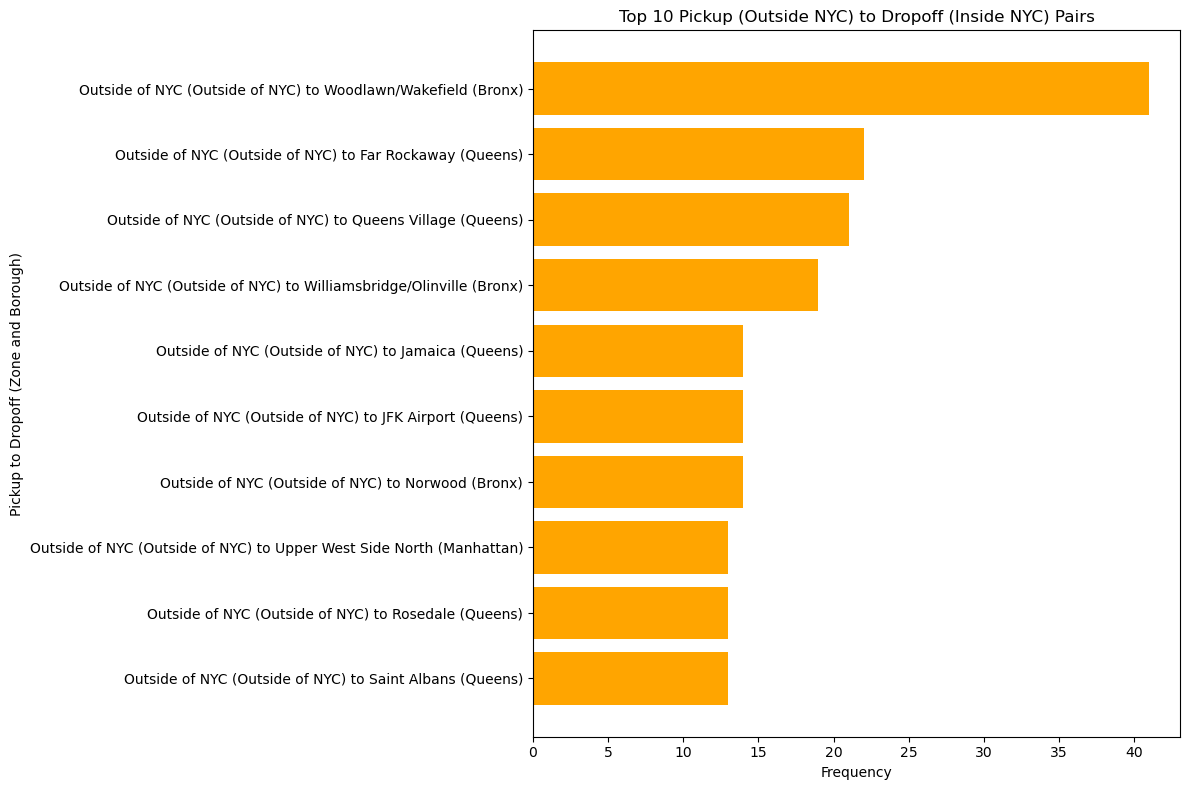

In [13]:
outside = trips[(trips['PULocationID'] == 265) | (trips['DOLocationID'] == 265)]
outside_od = outside.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='ODfrequency')

outside_od = outside_od.merge(zones[['LocationID', 'Zone', 'Borough']], 
                               left_on='PULocationID', right_on='LocationID', how='left').rename(columns={'Zone': 'PU_Zone', 'Borough': 'PU_Borough'})
outside_od = outside_od.merge(zones[['LocationID', 'Zone', 'Borough']], 
                               left_on='DOLocationID', right_on='LocationID', how='left').rename(columns={'Zone': 'DO_Zone', 'Borough': 'DO_Borough'})
outside_od['PU_Zone_Borough'] = outside_od['PU_Zone'] + ' (' + outside_od['PU_Borough'] + ')'
outside_od['DO_Zone_Borough'] = outside_od['DO_Zone'] + ' (' + outside_od['DO_Borough'] + ')'

# Top 10 Pickup and Dropoff Pairs (Outside NYC)
top_10_outside_od = outside_od.sort_values(by='ODfrequency', ascending=False).head(10)
plt.figure(figsize=(12, 8))
plt.barh(top_10_outside_od['PU_Zone_Borough'] + ' to ' + top_10_outside_od['DO_Zone_Borough'], 
         top_10_outside_od['ODfrequency'], color='purple')
plt.title('Top 10 Pickup and Dropoff Pairs (Outside NYC)')
plt.xlabel('Frequency')
plt.ylabel('Pickup to Dropoff (Zone and Borough)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_10_outside_pickup_dropoff.png', format='png', dpi=1200)
plt.show()

# Top 10 Pickup (Outside NYC) to Dropoff (Inside NYC) Pairs
outside_od = outside_od[outside_od['PULocationID'] == 265]
top_10_outside_od = outside_od.sort_values(by='ODfrequency', ascending=False).head(10)
plt.figure(figsize=(12, 8))
plt.barh(top_10_outside_od['PU_Zone_Borough'] + ' to ' + top_10_outside_od['DO_Zone_Borough'],
         top_10_outside_od['ODfrequency'], color='orange')
plt.title('Top 10 Pickup (Outside NYC) to Dropoff (Inside NYC) Pairs')
plt.xlabel('Frequency')
plt.ylabel('Pickup to Dropoff (Zone and Borough)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_10_outside_to_inside_pickup.png', format='png', dpi=1200)
plt.show()


**Temporal**

In [14]:
trips['hour'] = trips['pickup_datetime'].dt.hour
hour = trips.groupby('hour').size()
trips['weekday'] = trips['pickup_datetime'].dt.weekday
weekday = trips.groupby('weekday').size()
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday.index = weekday.index.map(lambda x: weekday_labels[x])

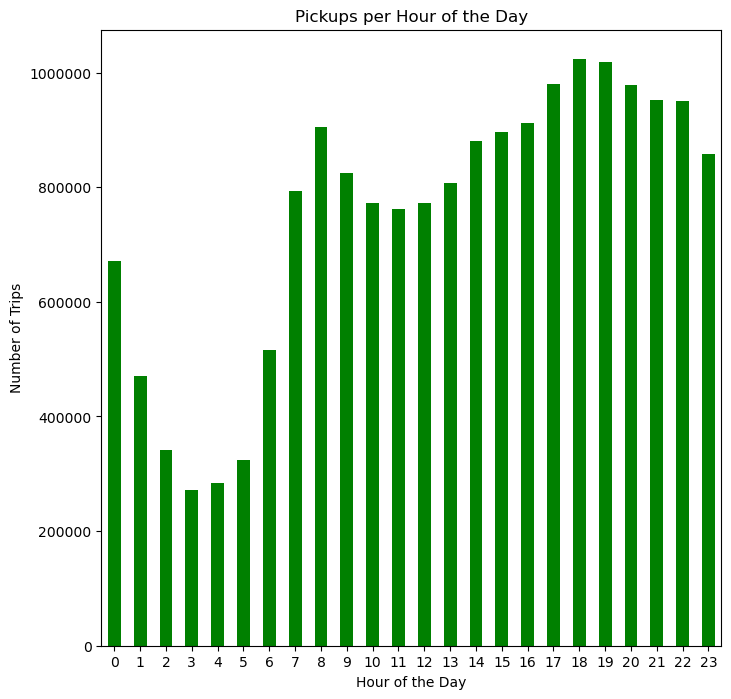

In [15]:
plt.figure(figsize=(8, 8))
hour.plot(kind='bar', color='green')
plt.title('Pickups per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.xticks(rotation=0)
plt.show()

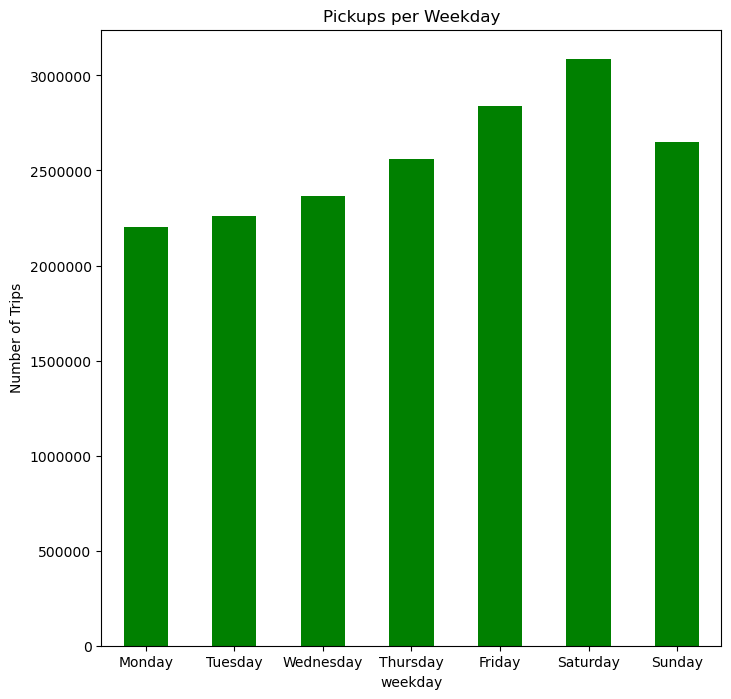

In [16]:
plt.figure(figsize=(8, 8))
weekday.plot(kind='bar', color='green')
plt.title('Pickups per Weekday')
plt.ylabel('Number of Trips')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.xticks(rotation=0)
plt.show()

**Combination**

In [20]:
trips['do_hour'] = trips['dropoff_datetime'].dt.hour
trips['do_hour_group'] = trips['do_hour'].apply(lambda x: f"_{x // 3 * 3}_{x // 3 * 3 + 2}")
trip_counts = trips.groupby(['do_hour_group', 'DOLocationID']).size().reset_index(name='do_trip_count')

In [21]:
trip_counts

,do_hour_group,DOLocationID,do_trip_count
0,_0_2,1,433
1,_0_2,2,1
2,_0_2,3,2677
3,_0_2,4,7579
4,_0_2,5,433
...,...,...,...
2077,_9_11,260,10673
2078,_9_11,261,11617
2079,_9_11,262,5289
2080,_9_11,263,9265


In [22]:
merged_geo_dfs = {}
for interval_name in trip_counts['do_hour_group'].unique():
    interval_data = trip_counts[trip_counts['do_hour_group'] == interval_name]
    merged_geo_dfs[interval_name] = geo.merge(interval_data, left_on='LocationID', right_on='DOLocationID', how='left')

<Figure size 1000x800 with 0 Axes>

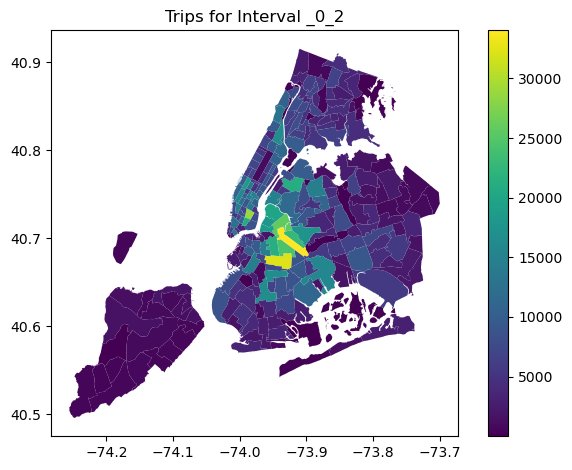

<Figure size 1000x800 with 0 Axes>

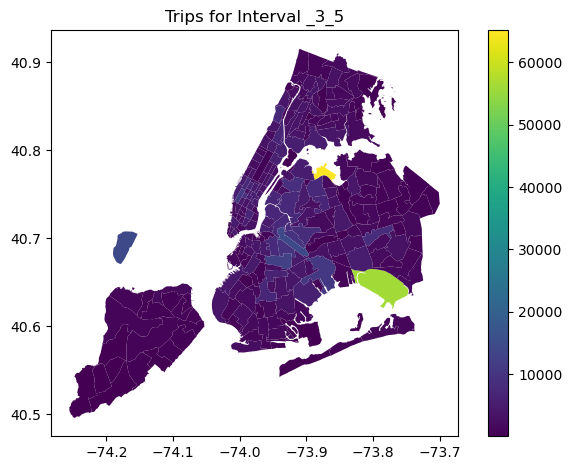

<Figure size 1000x800 with 0 Axes>

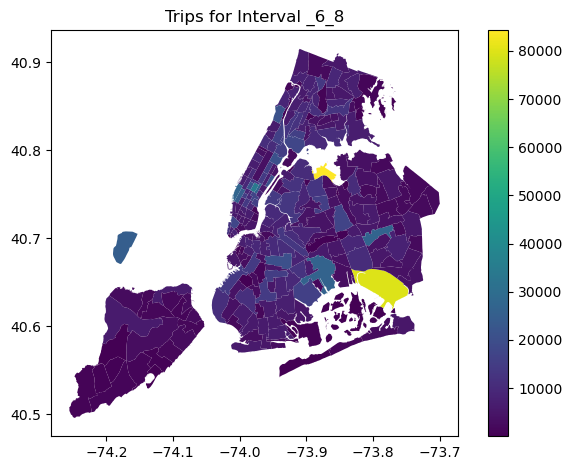

<Figure size 1000x800 with 0 Axes>

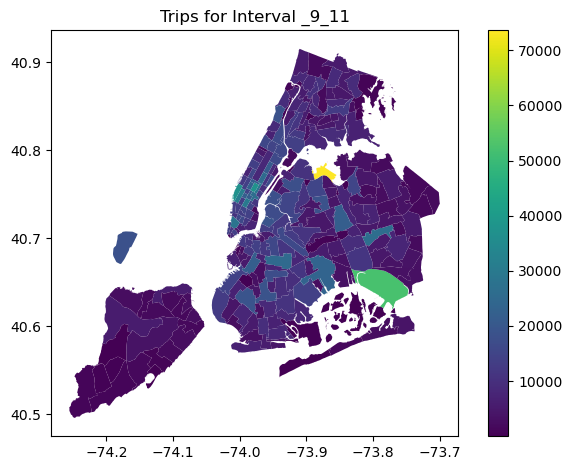

<Figure size 1000x800 with 0 Axes>

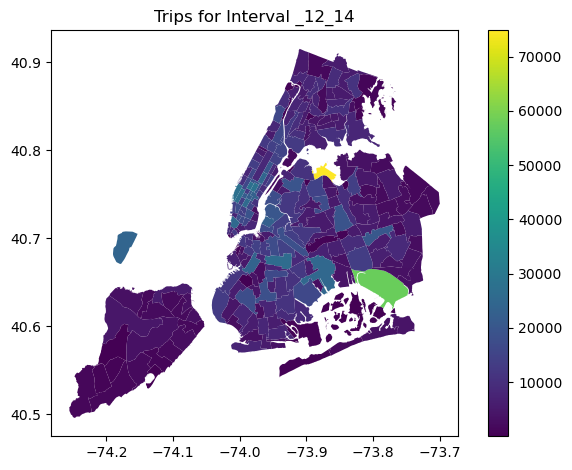

<Figure size 1000x800 with 0 Axes>

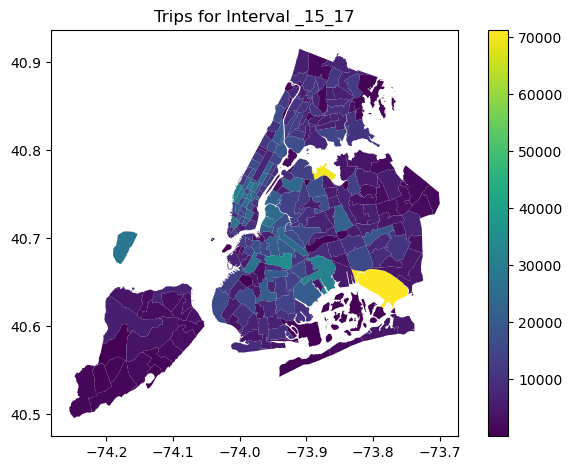

<Figure size 1000x800 with 0 Axes>

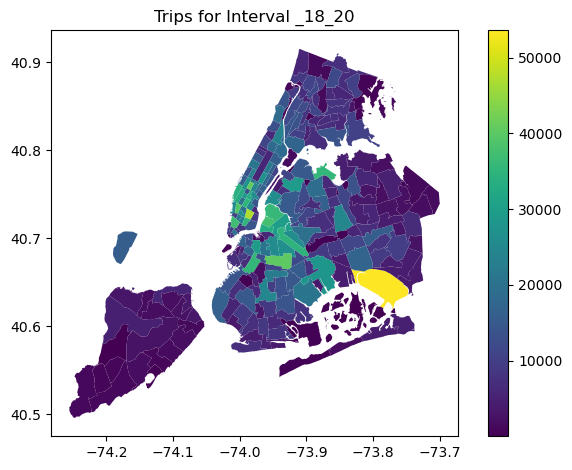

<Figure size 1000x800 with 0 Axes>

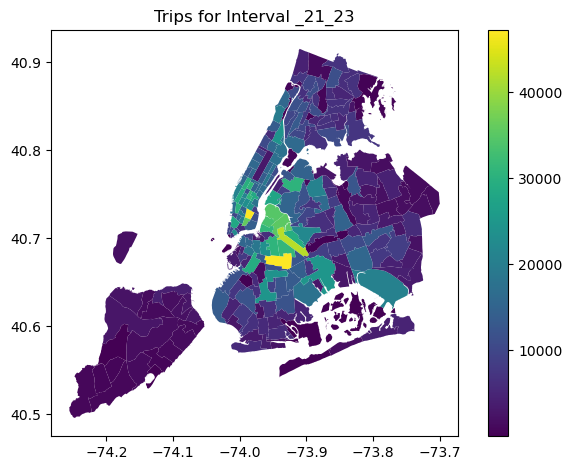

In [23]:
intervals = ["_0_2", "_3_5", "_6_8", "_9_11", "_12_14", "_15_17", "_18_20", "_21_23"]

for interval_name in intervals:
    df_to_plot = merged_geo_dfs[interval_name]
    
    plt.figure(figsize=(10, 8))
    df_to_plot.plot(column='do_trip_count', cmap='viridis', legend=True)
    plt.title(f"Trips for Interval {interval_name}")
    plt.tight_layout()
    
    filename = f"trips_interval{interval_name}.png"
    plt.savefig(filename, format='png', dpi=1200)
    plt.show()